In [0]:
%tensorflow_version 2.x
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (Dense,GlobalAveragePooling2D, Conv2D,
                          MaxPooling2D, AveragePooling2D, Flatten,Dropout,
                          concatenate, Input, BatchNormalization,
                          Activation, add, ZeroPadding2D) 
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard 
from glob import glob
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras.callbacks import History 
import tensorflow as tf
import shutil

from IPython.display import Image
from PIL import Image

Using TensorFlow backend.


In [0]:
# making sure GPU is avaliable
device_name = tf.test.gpu_device_name()
print(device_name)
if not device_name:
    raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

/device:GPU:0
Found GPU at: /device:GPU:0


In [0]:
def image_train_test_split(root_dir):
    """
        Splits each food category of images into train, test and validation folders.
    """
    train_path = root_dir +'/train'
    val_path = root_dir +'/validation'
    test_path = root_dir +'/test'

    if not os.path.exists(train_path):
        os.makedirs(train_path)

    if not os.path.exists(val_path):
        os.makedirs(val_path)

    if not os.path.exists(test_path):
        os.makedirs(test_path)

    # Creating partitions of the data after shuffeling
    for folder in [x.path for x in os.scandir(root_dir) if x.is_dir() and x.name not in ('test', 'train', 'validation')]:
    all_file_names = os.listdir(folder)
    np.random.shuffle(all_file_names)
    train_file_names, val_file_names, test_file_names = np.split(np.array(all_file_names),
                                                              [int(len(all_file_names)*0.7), int(len(all_file_names)*0.85)])

    folder = folder.split('/')[-1]
    if not os.path.exists(train_path + '/' + folder):
        os.makedirs(train_path + '/' + folder)
        os.makedirs(val_path + '/' + folder)
        os.makedirs(test_path + '/' + folder)

    train_file_names = [train_path + '/' + folder + '/' + name for name in train_file_names.tolist()]
    val_file_names = [val_path + '/' + folder + '/' + name for name in val_file_names.tolist()]
    test_file_names = [test_path + '/' + folder + '/' + name for name in test_file_names.tolist()]

    # Copy-pasting images
    for name in train_file_names:
        shutil.copy(root_dir + '/' + folder + '/' + name.split('/')[-1], train_path + '/' + folder)

    for name in val_file_names:
        shutil.copy(root_dir + '/' + folder + '/' + name.split('/')[-1], val_path + '/' + folder)

    for name in test_file_names:
        shutil.copy(root_dir + '/' + folder + '/' + name.split('/')[-1], test_path + '/' + folder)

In [ ]:
root_dir = 'Food images'
# image_train_test_split(root_dir)

In [0]:
def image_preprocessing(folders):
    """
        Load image and convert them to arrays.
        Divide by 255 to bring data to the scale from 0 to 1.
    """
    X , y = [], []
    for folder in tqdm(folders):
    all_file_names = os.listdir(folder)
    folder_name = folder.split('/')[-1]
    for file in all_file_names:
        img = Image.open(folder + '/' + file)
        img = img.resize((256,256))
        data = np.asarray(img) / 255.0
        X.append(data)
        y.append(folder_name)

    return X, y

In [ ]:
# path = root_dir +'/test'
# folders = [x.path for x in os.scandir(path) if x.is_dir()]
# x, y = image_preprocessing(folders)

In [0]:
def numpy_load(x_path, y_path):
    """
        For loading the numpy files from the data folder.
    """
    x = np.load(x_path, mmap_mode='r')
    y = np.load(y_path, mmap_mode='r')
    return x, y

In [ ]:
x_train, y_train = numpy_load('data/x_train.npy', 'data/y_train.npy')
x_val, y_val = numpy_load('data/x_val.npy', 'data/y_val.npy')
x_test, y_test = numpy_load('data/x_test.npy', 'data/y_test.npy')

In [0]:
lb = LabelBinarizer()
lb.fit(y_train)
y_train = lb.transform(y_train)
y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

In [0]:
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                  activation='relu',      
                  strides=1,              
                  padding='same',       
                  input_shape=input_shape,
                  use_bias=False))  

    model.add(Conv2D(16, kernel_size=(3, 3),
                  activation='relu',      
                  strides=1,              
                  padding='same',       
                  use_bias=False))   

    model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))              

    model.add(Conv2D(64, kernel_size=(3, 3),
                  activation='relu',
                  strides=2,               
                  padding='same',
                  use_bias=False))      

    model.add(Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    strides=1,               
                    padding='same',
                    use_bias=False)) 

    model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))              

    model.add(Conv2D(128, kernel_size=(3, 3),
                  activation='relu',
                  strides=1,               
                  padding='same',
                  use_bias=False))  

    model.add(Conv2D(64, kernel_size=(3, 3),
                  activation='relu',
                  strides=2,               
                  padding='same',
                  use_bias=False))                

    model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))              

    model.add(Conv2D(256, kernel_size=(3, 3),
                  activation='relu',
                  strides=1,               
                  padding='same',
                  use_bias=False))  

    model.add(Conv2D(128, kernel_size=(3, 3),
                  activation='relu',
                  strides=1,               
                  padding='same',
                  use_bias=False))  

    model.add(Conv2D(64, kernel_size=(3, 3),
                  activation='relu',
                  strides=1,               
                  padding='same',
                  use_bias=False))                           

    model.add(Conv2D(64, kernel_size=(3, 3),
                activation='relu',
                strides=1,               
                padding='same',
                use_bias=False))         

    model.add(MaxPooling2D(pool_size=(2, 2), strides=None))  
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Flatten())              

    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))              

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    model.summary()
    return model

In [0]:
input_shape = x_train.shape[1:]
n_classes = 5

In [0]:
history = History()

In [0]:
model = build_model(input_shape, n_classes)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      864       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      4608      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)      64        
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        9216      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        1

In [0]:
model.fit(x_train, y_train,
          batch_size=16,
          epochs=200,
          callbacks=[history],
          verbose=1,
          validation_data=(x_val, y_val))

Train on 3500 samples, validate on 750 samples
Epoch 1/200
3500/3500 [==============================] - 301s 86ms/sample - loss: 2.5538 - accuracy: 0.2646 - val_loss: 1.7079 - val_accuracy: 0.2747
Epoch 2/200
3500/3500 [==============================] - 8s 2ms/sample - loss: 1.7544 - accuracy: 0.3380 - val_loss: 1.6122 - val_accuracy: 0.2813
Epoch 3/200
3500/3500 [==============================] - 8s 2ms/sample - loss: 1.6287 - accuracy: 0.3666 - val_loss: 1.4670 - val_accuracy: 0.3960
Epoch 4/200
3500/3500 [==============================] - 8s 2ms/sample - loss: 1.4888 - accuracy: 0.4123 - val_loss: 1.6183 - val_accuracy: 0.4507
Epoch 5/200
3500/3500 [==============================] - 8s 2ms/sample - loss: 1.4173 - accuracy: 0.4431 - val_loss: 1.2710 - val_accuracy: 0.5693
Epoch 6/200
3500/3500 [==============================] - 8s 2ms/sample - loss: 1.3145 - accuracy: 0.4909 - val_loss: 2.3837 - val_accuracy: 0.2960
Epoch 7/200
3500/3500 [==============================] - 8s 2ms/samp

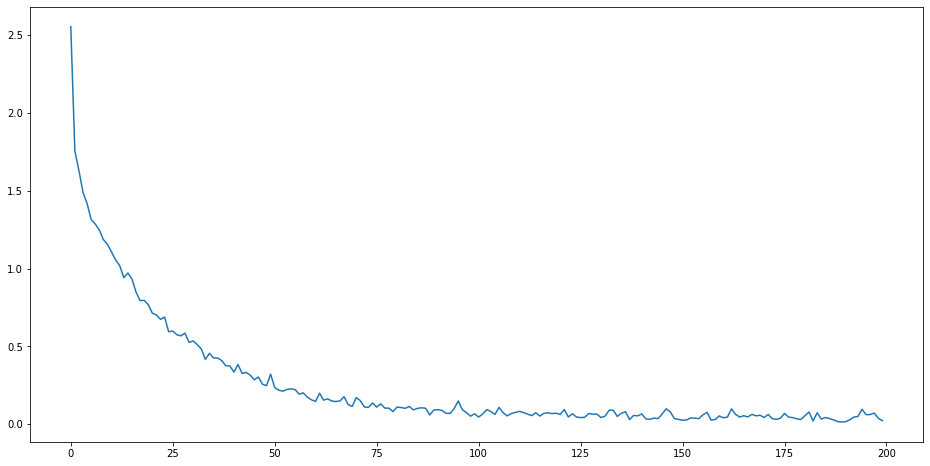

In [0]:
plt.figure(figsize = (16,8))
plt.plot(history.history['loss'],'-', label = 'Train')

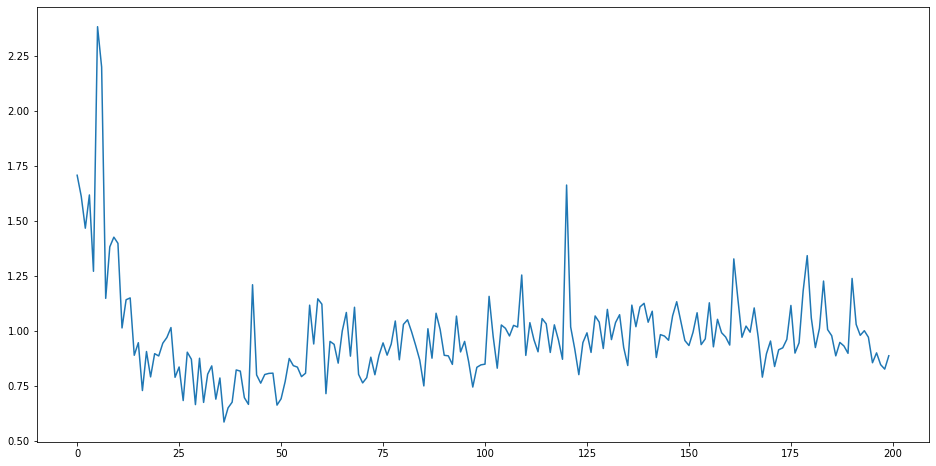

In [0]:
plt.figure(figsize = (16,8))
plt.plot(history.history['val_loss'],'-', label = 'Validation')

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1] * 100)

Test loss: 1.206753832658132
Test accuracy: 78.1333327293396


In [0]:
predicted_values = model.predict(x_test)

In [0]:
lb.classes_

array(['caesar_salad', 'carrot_cake', 'donuts', 'french_fries',
       'hamburger'], dtype='<U12')

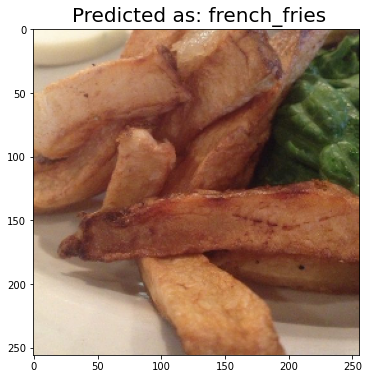

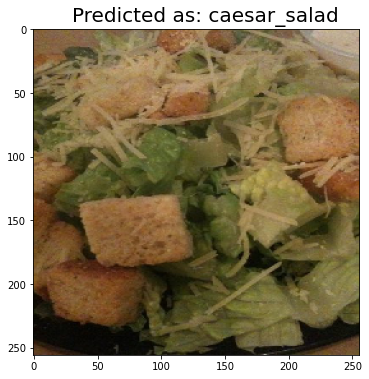

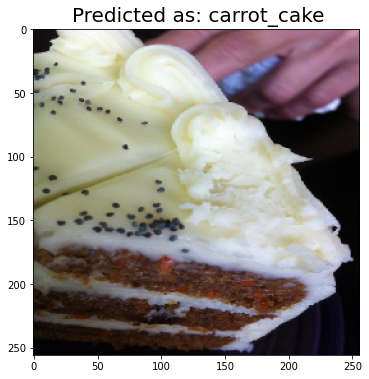

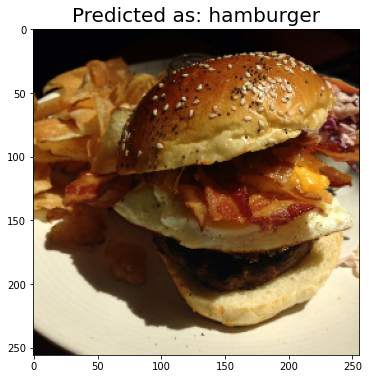

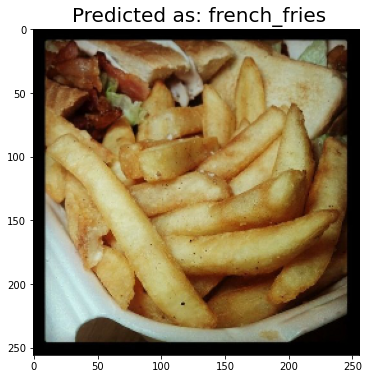

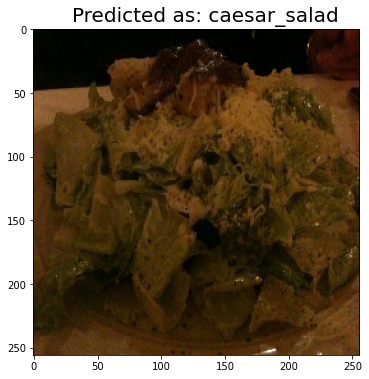

In [0]:
test = [463, 126, 268, 375, 596, 27]
for value in test:
    plt.figure(figsize=(9,6))
    plt.imshow(x_test[value])
    plt.annotate('Predicted as: ' + lb.classes_[np.argmax(predicted_values[value])], fontsize=20, xy=(.25, .75), xytext=(30, -6))

In [0]:
# Saving the model
saved_model_dir = 'saved_model/cnn_on_food101'
tf.saved_model.save(model, saved_model_dir)

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [0]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [0]:
with open('labels.txt', 'w') as f:
    for i in list(lb.classes_):
        f.write(i)

In [0]:
import gc
tf.keras.backend.clear_session()
del model
gc.collect()

1748